In [1]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
csv_path = 'combined_labels.csv'
df = pd.read_csv(csv_path)
df

,File Name,Label
0,common_voice_ta_31833527.wav,Tamil
1,common_voice_en_38025497.wav,English
2,common_voice_ta_31833176.wav,Tamil
3,common_voice_fr_34952338.wav,French
4,common_voice_en_38025197.wav,English
...,...,...
5035,common_voice_fr_38320456.wav,French
5036,common_voice_fr_38309889.wav,French
5037,common_voice_de_39579293.wav,German
5038,common_voice_pt_39209429.wav,Portuguese


In [3]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
#shuffled_df = shuffled_df[0:3000]


In [4]:
shuffled_df

,File Name,Label
0,common_voice_en_38025492.wav,English
1,common_voice_pt_36534887.wav,Portuguese
2,common_voice_ta_31833198.wav,Tamil
3,common_voice_de_36533364.wav,German
4,common_voice_ta_37358421.wav,Tamil
...,...,...
5035,common_voice_de_36533300.wav,German
5036,common_voice_ta_37342598.wav,Tamil
5037,common_voice_pt_39111485.wav,Portuguese
5038,common_voice_de_36534106.wav,German


In [5]:
data = {'language': ['Tamil', 'French', 'English', 'German', 'Portuguese', 'English', 'Tamil', 'French']}

label_counts = shuffled_df['Label'].value_counts()
print("Data distribution for each label:")
print(label_counts)

Data distribution for each label:
Portuguese    1013
French        1012
German        1009
Tamil         1008
English        998
Name: Label, dtype: int64


In [6]:
audio_dir = 'Data'

In [7]:
def load_and_preprocess(file_path):
    audio, _ = librosa.load(file_path, res_type='kaiser_fast', duration=2.5, sr=22050, offset=0.5)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    return mfccs

In [8]:
# Create a list to store MFCCs and labels
mfccs_list = []
labels = []

In [9]:
for index, row in shuffled_df.iterrows():
    file_path = os.path.join(audio_dir, row['File Name'])
    mfccs = load_and_preprocess(file_path)
    mfccs_list.append(mfccs.T)
    labels.append(row['Label'])

In [10]:
print(len(mfccs_list))
print(len(labels))

5040
5040


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_mfccs = pad_sequences(mfccs_list, dtype='float32', padding='post', truncating='post')

print(padded_mfccs.shape)

(5040, 108, 13)


In [12]:
X = np.array(padded_mfccs)
y = np.array(labels)

In [13]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [15]:
print(X_train[1].shape)

(108, 13)


In [43]:
from tensorflow.keras import models, layers

model_dnn = keras.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

In [44]:
print(model_dnn.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 108, 128)          1792      
                                                                 
 dropout_10 (Dropout)        (None, 108, 128)          0         
                                                                 
 dense_13 (Dense)            (None, 108, 64)           8256      
                                                                 
 dropout_11 (Dropout)        (None, 108, 64)           0         
                                                                 
 dense_14 (Dense)            (None, 108, 32)           2080      
                                                                 
 dropout_12 (Dropout)        (None, 108, 32)           0         
                                                                 
 flatten_2 (Flatten)         (None, 3456)             

In [45]:
model_dnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model_dnn.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/60
126/126 [==============================] - 19s 147ms/step - loss: 5.2528 - accuracy: 0.2195 - val_loss: 1.6027 - val_accuracy: 0.2718
Epoch 2/60
126/126 [==============================] - 18s 142ms/step - loss: 1.7076 - accuracy: 0.2235 - val_loss: 1.5560 - val_accuracy: 0.3125
Epoch 3/60
126/126 [==============================] - 19s 149ms/step - loss: 1.5536 - accuracy: 0.2783 - val_loss: 1.4935 - val_accuracy: 0.3581
Epoch 4/60
126/126 [==============================] - 19s 148ms/step - loss: 1.4166 - accuracy: 0.3390 - val_loss: 1.4805 - val_accuracy: 0.4067
Epoch 5/60
126/126 [==============================] - 18s 146ms/step - loss: 1.3411 - accuracy: 0.3616 - val_loss: 1.4335 - val_accuracy: 0.3512
Epoch 6/60
126/126 [==============================] - 18s 145ms/step - loss: 1.3130 - accuracy: 0.3715 - val_loss: 1.3007 - val_accuracy: 0.3790
Epoch 7/60
126/126 [==============================] - 19s 152ms/step - loss: 1.2661 - accuracy: 0.3839 - val_loss: 1.2377 - val_ac

126/126 [==============================] - 18s 146ms/step - loss: 0.2172 - accuracy: 0.9244 - val_loss: 0.6314 - val_accuracy: 0.8294
Epoch 58/60
126/126 [==============================] - 18s 142ms/step - loss: 0.2163 - accuracy: 0.9315 - val_loss: 0.6282 - val_accuracy: 0.8264
Epoch 59/60
126/126 [==============================] - 18s 142ms/step - loss: 0.1825 - accuracy: 0.9397 - val_loss: 0.6566 - val_accuracy: 0.8313
Epoch 60/60
126/126 [==============================] - 18s 145ms/step - loss: 0.1658 - accuracy: 0.9452 - val_loss: 0.6694 - val_accuracy: 0.8373


<Figure size 1200x400 with 0 Axes>

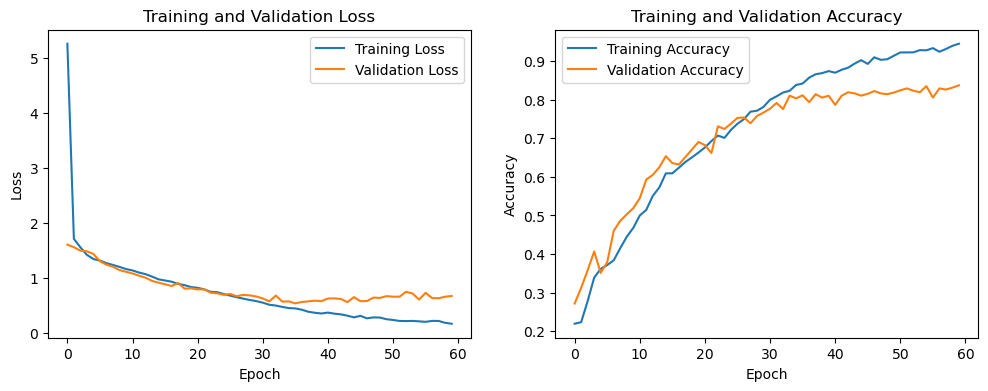

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [48]:
from sklearn.metrics import classification_report

In [49]:
y_pred_prob = model_dnn.predict(X_test)

32/32 [==============================] - 1s 34ms/step


In [50]:
y_pred_labels = np.argmax(y_pred_prob, axis=1)

In [51]:
y_test_labels = le.inverse_transform(y_test)

In [52]:
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8373015873015873


In [53]:
from sklearn.metrics import classification_report

In [54]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       199
           1       0.77      0.76      0.77       199
           2       0.83      0.83      0.83       201
           3       0.92      0.86      0.89       199
           4       0.99      0.93      0.96       210

    accuracy                           0.84      1008
   macro avg       0.84      0.84      0.84      1008
weighted avg       0.84      0.84      0.84      1008



## Personal English Voice

In [55]:
test_audio_path = 'english_test_audio.wav'
test_mfccs = load_and_preprocess(test_audio_path)

In [56]:
padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')


In [57]:
X_test_sample = np.array(padded_test_mfccs)

In [58]:
predictions = model_dnn.predict(X_test_sample)

1/1 [==============================] - 0s 19ms/step


In [59]:
predicted_label_index = np.argmax(predictions)
predicted_label = le.inverse_transform([predicted_label_index])[0]

print(f'Predicted Language: {predicted_label}')

Predicted Language: French


# English VoxLingual Test

In [60]:
test_folder_path = 'English_test_Vox'

In [61]:
english_count = 0

# Iterate through all WAV files in the folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_dnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'English':
            english_count += 1


1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S0---0366.650-0375.120.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S0---0376.220-0382.610.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S0---0524.480-0539.440.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S0---0954.160-0969.530.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S1---0085.040-0101.490.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S1---0101.490-0108.830.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S1---0128.750-0137.040.wav, Predicted Language: German
1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S1---0137.040-0142.

1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S105---0657.000-0670.360.wav, Predicted Language: German
1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S105---0784.720-0790.460.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S105---0790.460-0805.010.wav, Predicted Language: German
1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S105---0871.580-0882.460.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S107---0067.170-0074.660.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S107---0670.360-0679.430.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S107---0714.900-0727.300.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S107--

In [62]:
print(f'Total English Predictions: {english_count}')

Total English Predictions: 37


In [63]:
test_folder_path = 'German_test_Vox'

German_count = 0
# Iterate through all WAV files in the folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_dnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'German':
            German_count += 1


1/1 [==============================] - 0s 19ms/step
File: 0GLLVyNCo3Y__U__S1---0004.530-0021.000.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 19ms/step
File: 0GLLVyNCo3Y__U__S4---0021.000-0037.560.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0GLLVyNCo3Y__U__S4---0037.560-0053.560.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: 0MsifTxSdKw__U__S0---0150.320-0163.790.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 21ms/step
File: 0MsifTxSdKw__U__S0---0164.400-0179.760.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 19ms/step
File: 0MsifTxSdKw__U__S0---0251.380-0261.620.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 20ms/step
File: 0MsifTxSdKw__U__S0---0398.450-0406.110.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0MsifTxSdKw__U__S0--

1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S108---0915.050-0922.230.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 21ms/step
File: _zTNE3kvaGg__U__S108---0928.770-0935.790.wav, Predicted Language: German
1/1 [==============================] - 0s 20ms/step
File: _zTNE3kvaGg__U__S108---0937.030-0940.360.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S108---0940.360-0946.000.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S108---0946.000-0964.760.wav, Predicted Language: German
1/1 [==============================] - 0s 20ms/step
File: _zTNE3kvaGg__U__S108---0964.760-0975.170.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S150---0984.770-0991.090.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S150

In [64]:
print(f'Total German Predictions: {German_count}')

Total German Predictions: 50


In [68]:
test_folder_path = 'Portuguese_test_Vox'

Portuguese_count = 0
# Iterate through all WAV files in the folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_dnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'Portuguese':
            Portuguese_count += 1

1/1 [==============================] - 0s 14ms/step
File: 0RqxhbSC1qE__U__S1---0011.370-0018.140.wav, Predicted Language: German
1/1 [==============================] - 0s 17ms/step
File: 0RqxhbSC1qE__U__S1---0018.480-0024.450.wav, Predicted Language: English
1/1 [==============================] - 0s 16ms/step
File: 0RqxhbSC1qE__U__S1---0024.630-0032.410.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---0061.140-0067.480.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---0235.420-0239.590.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---0249.890-0257.460.wav, Predicted Language: English
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---0258.150-0264.620.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S1---0444.870-0450.0

1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---2867.300-2871.450.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S1---2875.880-2880.200.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S1---2915.860-2919.680.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S10---0075.870-0080.440.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S10---0087.050-0090.680.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S38---0267.840-0278.060.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S38---0310.240-0318.790.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: 0RqxhbSC1qE__U__S38---0318.95

In [69]:
print(f'Total Portuguese Predictions: {Portuguese_count}')

Total Portuguese Predictions: 1
